<a href="https://colab.research.google.com/github/VuongTuanKhanh/Funix-Capstone-Project/blob/main/notebooks/Airborne_Object_Detection_Benchmark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://user-images.githubusercontent.com/26833433/125273437-35b3fc00-e30d-11eb-9079-46f313325424.png">

This is the **official notebook 🚀** by [Tuan Khanh](https://github.com/VuongTuanKhanh), and is freely available for redistribution under the [MIT license](https://opensource.org/licenses/MIT). 

This tutorial will help you build objects detections models easily in the cloud with **GPU** enabled so that you can run real-time object detections as well as train your very own custom object detector!

First of all, you will need to enable **GPU** acceleration within your **Colab Notebook** so that your system will be able to process detections over 100 faster than **CPU**.

<details>

- Click **Edit** at top left of your notebook

![image.png](https://raw.githubusercontent.com/VuongTuanKhanh/Funix-Capstone-Project/main/images/gpu_1.png)

- Click **Notebook Settings** within dropdown

![image.png](https://raw.githubusercontent.com/VuongTuanKhanh/Funix-Capstone-Project/main/images/gpu_2.png)

- Under 'Hardware Accelerator' select **GPU** and then hit **Save**

![image.png](https://raw.githubusercontent.com/VuongTuanKhanh/Funix-Capstone-Project/main/images/gpu_3.png)

Your notebook should now have GPU enabled!

</details>

For more information please visit https://github.com/VuongTuanKhanh/Funix-Capstone-Project. Thank you!

# 🤫 Setting Up

## 💽 Create Google Drive repository

In [1]:
import json
import random
import os, sys
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"]=25,25
from random import randrange, choice
from IPython.display import display, clear_output, HTML

We will need to mount with **Google Drive** as we treat it as a local file. Whether you are using **Jupyter Notebook** instead of **Google Colab**, you can skip this step. 

However, since our data set is huge, it would not be feasible to store it locally. Instead, I recommend using **Google Drive** as a cloud storage drive, which will help us store more efficiently and access it more easily in the future.

In [2]:
# Check the ipython interpreter is being used
if 'google.colab' in str(get_ipython()):
    # Import Library
    from google.colab import drive
    # Mounting Drive Folder
    try:
        drive.mount('/content/drive')
    except:
        print("Mounting Fail")
    else:
        print("Mouting Success")
    finally:
        print("Mounting process is completed")

    # Define the path to the Google Drive Folder
    drive_path = "/content/drive/MyDrive/Funix-Capstone-Project"

    # Clone the repo if the folder whether it is not existed
    if not os.path.exists(drive_path):
        # Install 'git' module if needed
        try:
            from git import Repo
        except ModuleNotFoundError:
            import sys, subprocess
            print("Installing 'git' module")
            subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'gitpython'])

        # Import 'repo' from 'git' module
        from git import Repo
        # Create project folder
        os.mkdir(drive_path)
        # Clone the repo
        Repo.clone_from("https://github.com/VuongTuanKhanh/Funix-Capstone-Project", drive_path)
        print("Cloning git repo")


    # Navigate to the folder
    os.chdir(drive_path)

Mounted at /content/drive
Mouting Success
Mounting process is completed


To run the project, you need to install the packages specified in the requirements section. 

The installation will be done automatically when all the packages have been specified in advance and done through the shell command, automatically installed into the Linux operating system of the virtual machine.

In [ ]:
# Install the required package
!pip install -r ./requirements.txt > /dev/null

# Clearing the output
clear_output()

## 🔬 Accessing AOT Dataset

After we have finished setting up the environment, we will proceed to access the data. Detailed information on the data as well as example steps of exploration can be found [here](https://github.com/VuongTuanKhanh/Funix-Capstone-Project/wiki/About-the-AOT-dataset) and [here](https://github.com/VuongTuanKhanh/Funix-Capstone-Project/blob/main/notebooks/Dataset_Exploration.ipynb). For more information you can refer to my Github Repo Wiki located at https://github.com/VuongTuanKhanh/Funix-Capstone-Project


We will need to load the details of all flights based on the grouthtruth information provided in the original dataset. Execution will be done automatically based on my self-defined library in the core directory, including setting up paths as well as loading grouthtruth information for all flights. This information is then saved into a single object for easy access.


Note, it is necessary to consider loading the whole data or just a part of the data when the original data set is really large, up to 13Tb, making it sometimes impossible to load and store each record. Instead, you can choose to load a partial data including 500Gb of valid encounters via the `partial=True` option.


Detailed information about the dataset as well as `grouthtruth` and `valid_encounter` formats can be found [here](https://github.com/VuongTuanKhanh/Funix-Capstone-Project/wiki/Downloading-AOT-dataset).

In [ ]:
from core.helper import initialize, load_data

# Initialize the enviroment
initialize(42)

# Loading the dataset and save to a variable
# Whether you want to load the entire dataset, use partial=False
dataset = load_data()

# Print out the dataset
print(dataset)

2021-08-29 08:10:00.620 | INFO     | core.dataset:load_gt:28 - Loading ground truth...
2021-08-29 08:10:42.524 | INFO     | core.dataset:load_gt:28 - Loading ground truth...
2021-08-29 08:11:20.450 | INFO     | core.dataset:load_gt:28 - Loading ground truth...


Dataset(num_flights=3438)


## 📡 Downloading all images for training

Please note, **downloading image for each frame** would be slower, so when using for training downloading whole dataset is preferred. 

You can download full dataset using following commands:

```python
for flight in dataset.flights:
    # This can take upto 5-10 mins on Colab
    flight.download()
```

The original data is stored on the **AWS server**, so you can also mount the data directly by using **EFS** or **s3fs**. End-to-end example can be found [here](https://github.com/VuongTuanKhanh/Funix-Capstone-Project/blob/main/notebooks/EFS_and_S3FS_example.ipynb).


# Improve the Baseline

As we can see, naively and blindly applying pre-train **YOLOv3** model will not give good predictive performance on **AOT** dataset. Some may argue that **YOLOv3** is not trained on the plane object. However, in fact, **YOLOv3** is trained on the **COCO** dataset, with 80 different classes, including airplane (you can refer [here](https://gist.github.com/AruniRC/7b3dadd004da04c80198557db5da4bda) for more information about **COCO classes**), so the above argument is not acceptable.

So in this step, we will go through different solutions together, which include retraining our model, explicitly specifying the objects to be learned, to improve our prediction performance.

Improvements will be made through re-training the **YOLO** model in different versions, specifying the **AOT** dataset. So, let's start with pre-processing our dataset.

Training **YOLOv3** with **AOT** requires creating a suitable dataset as well as labels that conform to the **YOLO** format, as well as re-config many files. You can refer to this [document](https://github.com/VuongTuanKhanh/Funix-Capstone-Project/wiki/Train-YOLOv3-with-the-AOT-Dataset) for more details.

**NOTE**: If you want to embedd your very own custom dataset, please refer to [this](https://github.com/VuongTuanKhanh/Funix-Capstone-Project/wiki/Collecting-Custom-Data).

In [11]:
# Import self-define class
from core.yolo_v3 import Yolo_V3
# Create an instance for the class
yolo_v3 = Yolo_V3()

In [ ]:
# make darknet (build)
!make
clear_output()

## Create Training Dataset for Yolo models

In [ ]:
# Import the self-define class
from core.yolo_data import Yolo_Data
# Create an instance
yolo_data = Yolo_Data()
# Generate training datas and labels
yolo_data.generate_data(dataset)

Iterating through ./data/part1/Images
Iterating through ./data/part2/Images
Iterating through ./data/part3/Images
Generating train.txt
Generating test.txt
Generating original_paths.txt
Finish Generating !!! Total of 48607 images and 110546 objects


## Training a Custom Object Detector in the Cloud!

### Yolo Files Configuration

#### Modify path configuration

In [ ]:
if not os.path.exists("./data/obj.data"):
    open("./data/obj.data", 'a').close()

In [ ]:
%%file ./data/obj.data
classes = 1
train = data/train.txt
valid = data/test.txt
names = data/obj.names
backup = backup/

Overwriting ./data/obj.data


#### Modify labels name

In [ ]:
if not os.path.exists("./data/obj.names"):
    open("./data/obj.names", 'a').close()

In [ ]:
%%file ./data/obj.names
Airborne_Object

Overwriting ./data/obj.names


### Custom YOLOv3

#### Download pre-trained weight for YOLOv3

In [ ]:
# upload pretrained convolutional layer weights
if not os.path.exists("darknet53.conv.74"):
    yolo_v3.wget_package("darknet53.conv.74", "http://pjreddie.com/media/files/darknet53.conv.74")

#### Modify config file

In [ ]:
%%file ./cfg/yolov3.cfg
[net]
# Testing
# batch=1
# subdivisions=64
# Training
batch=64
subdivisions=64
width=416
height=416
channels=3
momentum=0.9
decay=0.0005
angle=0
saturation = 1.5
exposure = 1.5
hue=.1

learning_rate=0.001
burn_in=1000
max_batches = 2000
policy=steps
steps=1600,1800
scales=.1,.1

[convolutional]
batch_normalize=1
filters=32
size=3
stride=1
pad=1
activation=leaky

# Downsample

[convolutional]
batch_normalize=1
filters=64
size=3
stride=2
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=32
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=64
size=3
stride=1
pad=1
activation=leaky

[shortcut]
from=-3
activation=linear

# Downsample

[convolutional]
batch_normalize=1
filters=128
size=3
stride=2
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=64
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=128
size=3
stride=1
pad=1
activation=leaky

[shortcut]
from=-3
activation=linear

[convolutional]
batch_normalize=1
filters=64
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=128
size=3
stride=1
pad=1
activation=leaky

[shortcut]
from=-3
activation=linear

# Downsample

[convolutional]
batch_normalize=1
filters=256
size=3
stride=2
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=128
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=256
size=3
stride=1
pad=1
activation=leaky

[shortcut]
from=-3
activation=linear

[convolutional]
batch_normalize=1
filters=128
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=256
size=3
stride=1
pad=1
activation=leaky

[shortcut]
from=-3
activation=linear

[convolutional]
batch_normalize=1
filters=128
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=256
size=3
stride=1
pad=1
activation=leaky

[shortcut]
from=-3
activation=linear

[convolutional]
batch_normalize=1
filters=128
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=256
size=3
stride=1
pad=1
activation=leaky

[shortcut]
from=-3
activation=linear


[convolutional]
batch_normalize=1
filters=128
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=256
size=3
stride=1
pad=1
activation=leaky

[shortcut]
from=-3
activation=linear

[convolutional]
batch_normalize=1
filters=128
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=256
size=3
stride=1
pad=1
activation=leaky

[shortcut]
from=-3
activation=linear

[convolutional]
batch_normalize=1
filters=128
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=256
size=3
stride=1
pad=1
activation=leaky

[shortcut]
from=-3
activation=linear

[convolutional]
batch_normalize=1
filters=128
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=256
size=3
stride=1
pad=1
activation=leaky

[shortcut]
from=-3
activation=linear

# Downsample

[convolutional]
batch_normalize=1
filters=512
size=3
stride=2
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=256
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=512
size=3
stride=1
pad=1
activation=leaky

[shortcut]
from=-3
activation=linear


[convolutional]
batch_normalize=1
filters=256
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=512
size=3
stride=1
pad=1
activation=leaky

[shortcut]
from=-3
activation=linear


[convolutional]
batch_normalize=1
filters=256
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=512
size=3
stride=1
pad=1
activation=leaky

[shortcut]
from=-3
activation=linear


[convolutional]
batch_normalize=1
filters=256
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=512
size=3
stride=1
pad=1
activation=leaky

[shortcut]
from=-3
activation=linear

[convolutional]
batch_normalize=1
filters=256
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=512
size=3
stride=1
pad=1
activation=leaky

[shortcut]
from=-3
activation=linear


[convolutional]
batch_normalize=1
filters=256
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=512
size=3
stride=1
pad=1
activation=leaky

[shortcut]
from=-3
activation=linear


[convolutional]
batch_normalize=1
filters=256
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=512
size=3
stride=1
pad=1
activation=leaky

[shortcut]
from=-3
activation=linear

[convolutional]
batch_normalize=1
filters=256
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=512
size=3
stride=1
pad=1
activation=leaky

[shortcut]
from=-3
activation=linear

# Downsample

[convolutional]
batch_normalize=1
filters=1024
size=3
stride=2
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=512
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=1024
size=3
stride=1
pad=1
activation=leaky

[shortcut]
from=-3
activation=linear

[convolutional]
batch_normalize=1
filters=512
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=1024
size=3
stride=1
pad=1
activation=leaky

[shortcut]
from=-3
activation=linear

[convolutional]
batch_normalize=1
filters=512
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=1024
size=3
stride=1
pad=1
activation=leaky

[shortcut]
from=-3
activation=linear

[convolutional]
batch_normalize=1
filters=512
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=1024
size=3
stride=1
pad=1
activation=leaky

[shortcut]
from=-3
activation=linear

######################

[convolutional]
batch_normalize=1
filters=512
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
size=3
stride=1
pad=1
filters=1024
activation=leaky

[convolutional]
batch_normalize=1
filters=512
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
size=3
stride=1
pad=1
filters=1024
activation=leaky

[convolutional]
batch_normalize=1
filters=512
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
size=3
stride=1
pad=1
filters=1024
activation=leaky

[convolutional]
size=1
stride=1
pad=1
filters=18
activation=linear


[yolo]
mask = 6,7,8
anchors = 10,13,  16,30,  33,23,  30,61,  62,45,  59,119,  116,90,  156,198,  373,326
classes=1
num=9
jitter=.3
ignore_thresh = .7
truth_thresh = 1
random=0


[route]
layers = -4

[convolutional]
batch_normalize=1
filters=256
size=1
stride=1
pad=1
activation=leaky

[upsample]
stride=2

[route]
layers = -1, 61



[convolutional]
batch_normalize=1
filters=256
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
size=3
stride=1
pad=1
filters=512
activation=leaky

[convolutional]
batch_normalize=1
filters=256
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
size=3
stride=1
pad=1
filters=512
activation=leaky

[convolutional]
batch_normalize=1
filters=256
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
size=3
stride=1
pad=1
filters=512
activation=leaky

[convolutional]
size=1
stride=1
pad=1
filters=18
activation=linear


[yolo]
mask = 3,4,5
anchors = 10,13,  16,30,  33,23,  30,61,  62,45,  59,119,  116,90,  156,198,  373,326
classes=1
num=9
jitter=.3
ignore_thresh = .7
truth_thresh = 1
random=0



[route]
layers = -4

[convolutional]
batch_normalize=1
filters=128
size=1
stride=1
pad=1
activation=leaky

[upsample]
stride=2

[route]
layers = -1, 36



[convolutional]
batch_normalize=1
filters=128
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
size=3
stride=1
pad=1
filters=256
activation=leaky

[convolutional]
batch_normalize=1
filters=128
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
size=3
stride=1
pad=1
filters=256
activation=leaky

[convolutional]
batch_normalize=1
filters=128
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
size=3
stride=1
pad=1
filters=256
activation=leaky

[convolutional]
size=1
stride=1
pad=1
filters=18
activation=linear


[yolo]
mask = 0,1,2
anchors = 10,13,  16,30,  33,23,  30,61,  62,45,  59,119,  116,90,  156,198,  373,326
classes=1
num=9
jitter=.3
ignore_thresh = .7
truth_thresh = 1
random=0

Overwriting ./cfg/yolov3.cfg


#### Train YOLOv3 on AOT dataset

In [ ]:
# !./darknet detector train data/obj.data cfg/yolov3.cfg darknet53.conv.74 -dont_show -map
!./darknet detector train data/obj.data cfg/yolov3.cfg ./backup/yolov3_last.weights -dont_show -map

 CUDA-version: 11000 (11020), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 Prepare additional network for mAP calculation...
 0 : compute_capability = 370, cudnn_half = 0, GPU: Tesla K80 
net.optimized_memory = 0 
mini_batch = 1, batch = 64, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 -

You can observe a chart of how your model did throughout the training process by running the below command. It shows a chart of your average loss vs. iterations. For your model to be 'accurate' you would aim for a loss under 2.

#### Run our YOLOv3 Custom Object Detector!!!

In [ ]:
# need to set our custom cfg to test mode 
%cd cfg
!sed -i 's/batch=64/batch=1/' yolov3.cfg
!sed -i 's/subdivisions=16/subdivisions=1/' yolov3.cfg
%cd ..

/content/drive/My Drive/Airborne-Object-Tracking/darknet/cfg
/content/drive/My Drive/Airborne-Object-Tracking/darknet


In [ ]:
!./darknet detector test data/obj.data cfg/yolov3.cfg ./backup/yolov3_last.weights ../data/part1/Images/49f4d9ca19004b81b905db6acab3d7d8/153610618516003474949f4d9ca19004b81b905db6acab3d7d8.png -thresh 0.3

 CUDA-version: 11000 (11020), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 750, cudnn_half = 0, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 64, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
   8 Shortcut Layer: 5, 

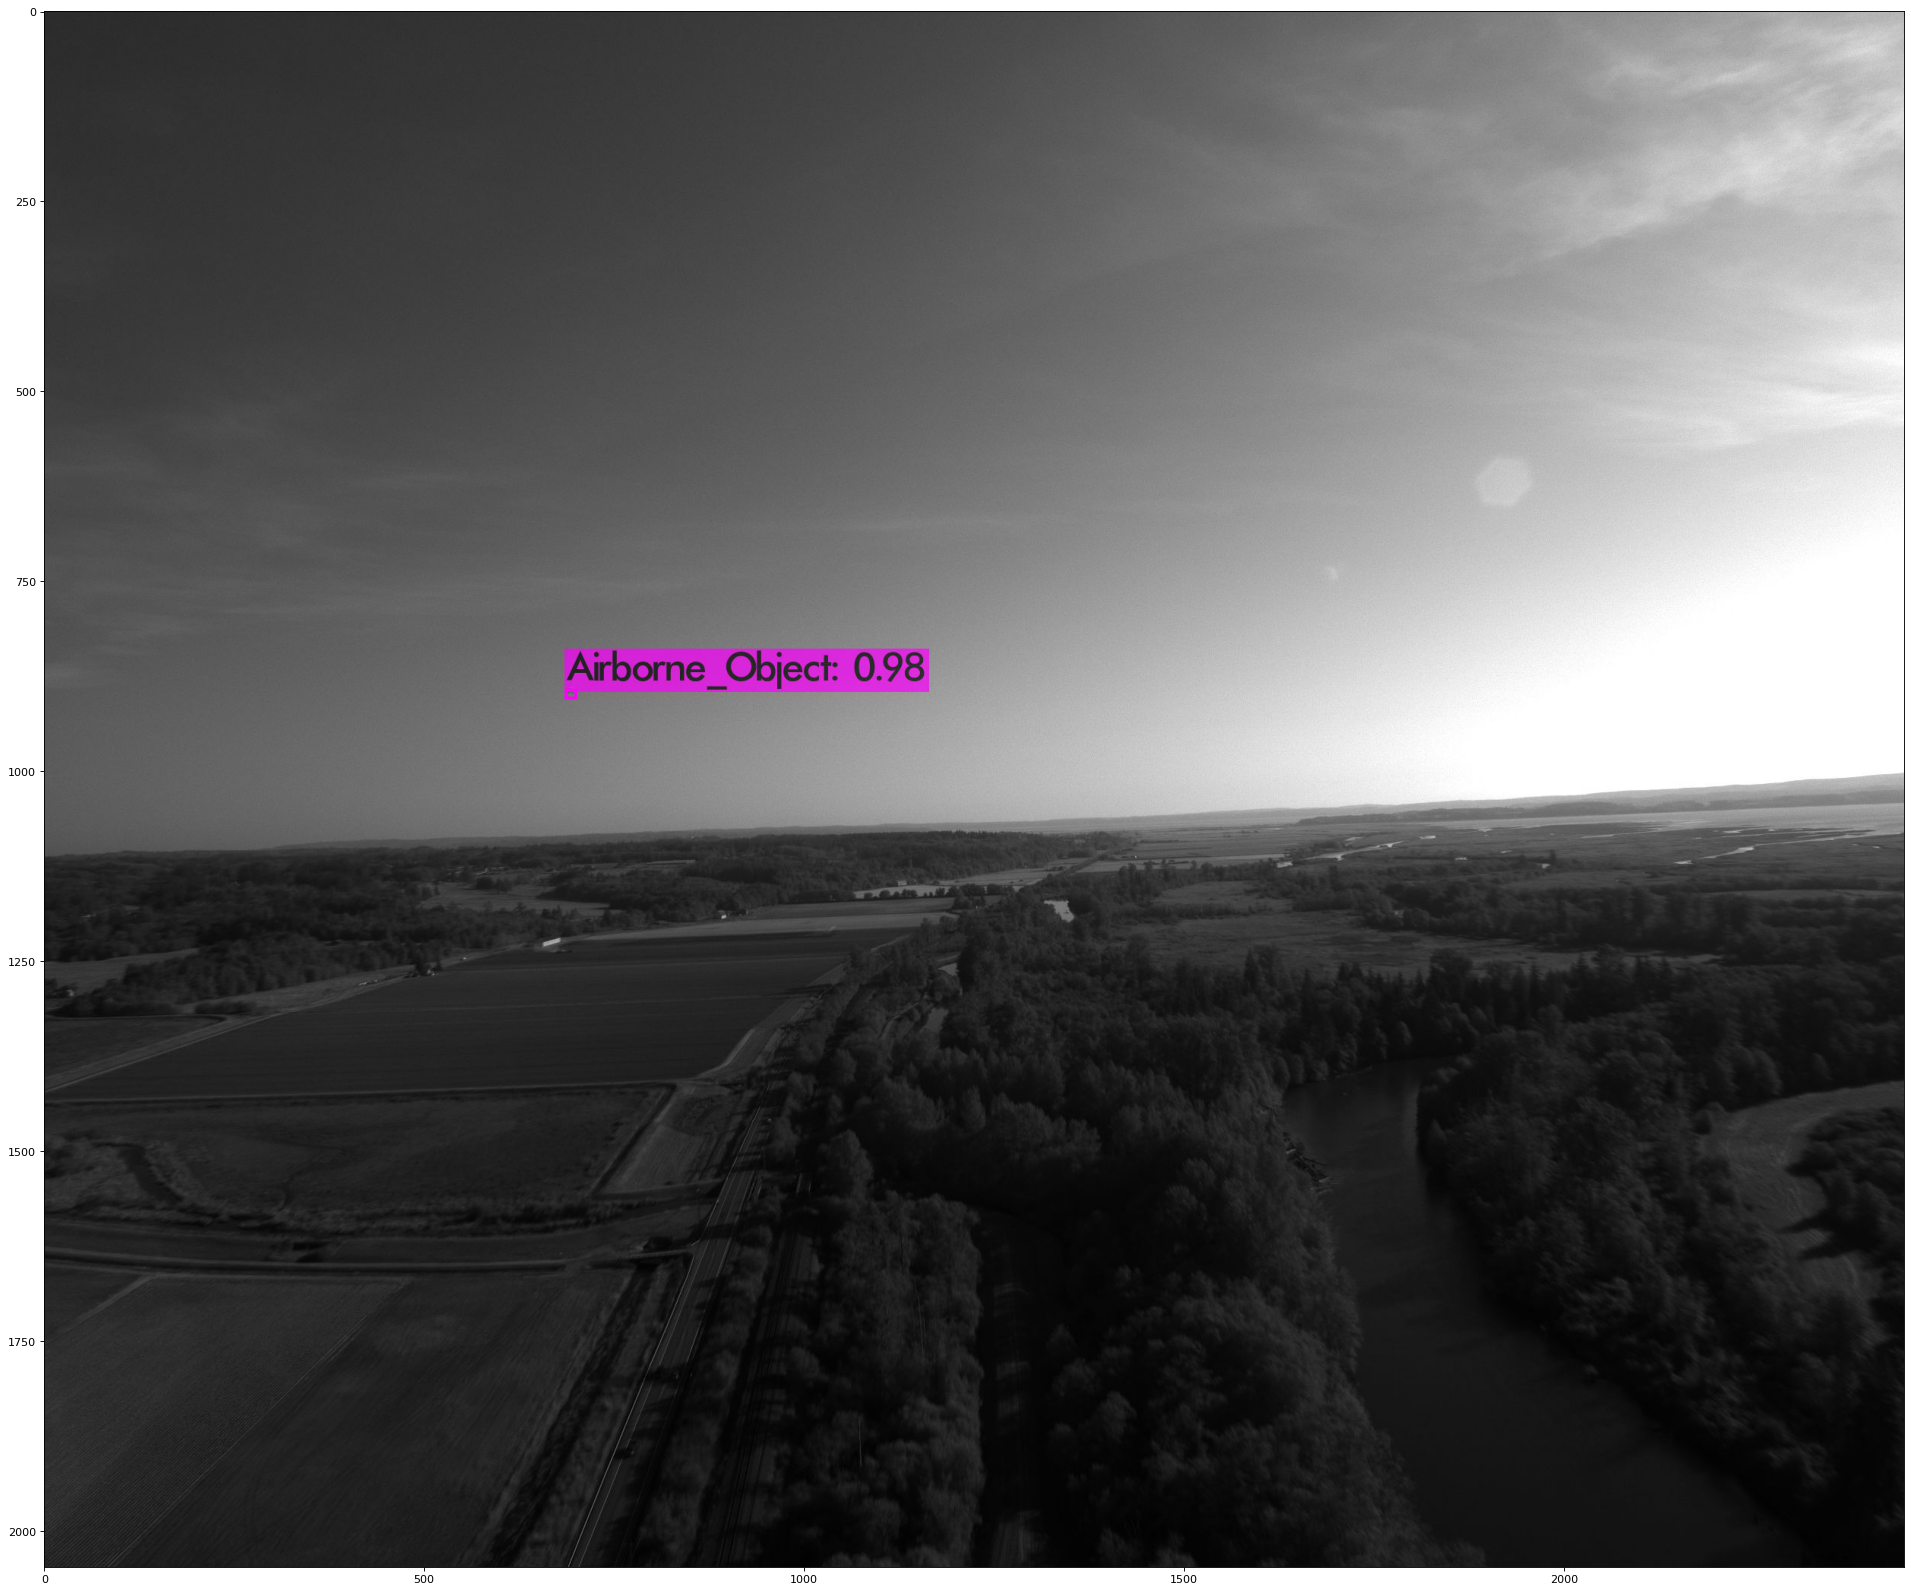

In [ ]:
yolo_v3.plot_image('predictions.jpg')

### Custom YOLOv4

##### Download pre-trained weight for YOLOv4

In [ ]:
if not os.path.exists("yolov4.conv.137"):
    yolo_v3.wget_package("yolov4.conv.137", "https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.conv.137")

Module 'git' is not installed ! 
 Installing ...
Finish installation !!!
Finish download yolov4.conv.137


#### Modify YOLOv4 Config file

In [ ]:
%%file /content/drive/MyDrive/Funix-Capstone-Project/darknet/cfg/yolov4-custom.cfg
[net]
# Testing
# batch=1
# subdivisions=64
# Training
batch=64
subdivisions=64
width=608
height=608
channels=3
momentum=0.949
decay=0.0005
angle=0
saturation = 1.5
exposure = 1.5
hue=.1

learning_rate=0.001
burn_in=1000
max_batches = 2000
policy=steps
steps=1600,1800
scales=.1,.1

#cutmix=1
mosaic=1

#:104x104 54:52x52 85:26x26 104:13x13 for 416

[convolutional]
batch_normalize=1
filters=32
size=3
stride=1
pad=1
activation=mish

# Downsample

[convolutional]
batch_normalize=1
filters=64
size=3
stride=2
pad=1
activation=mish

[convolutional]
batch_normalize=1
filters=64
size=1
stride=1
pad=1
activation=mish

[route]
layers = -2

[convolutional]
batch_normalize=1
filters=64
size=1
stride=1
pad=1
activation=mish

[convolutional]
batch_normalize=1
filters=32
size=1
stride=1
pad=1
activation=mish

[convolutional]
batch_normalize=1
filters=64
size=3
stride=1
pad=1
activation=mish

[shortcut]
from=-3
activation=linear

[convolutional]
batch_normalize=1
filters=64
size=1
stride=1
pad=1
activation=mish

[route]
layers = -1,-7

[convolutional]
batch_normalize=1
filters=64
size=1
stride=1
pad=1
activation=mish

# Downsample

[convolutional]
batch_normalize=1
filters=128
size=3
stride=2
pad=1
activation=mish

[convolutional]
batch_normalize=1
filters=64
size=1
stride=1
pad=1
activation=mish

[route]
layers = -2

[convolutional]
batch_normalize=1
filters=64
size=1
stride=1
pad=1
activation=mish

[convolutional]
batch_normalize=1
filters=64
size=1
stride=1
pad=1
activation=mish

[convolutional]
batch_normalize=1
filters=64
size=3
stride=1
pad=1
activation=mish

[shortcut]
from=-3
activation=linear

[convolutional]
batch_normalize=1
filters=64
size=1
stride=1
pad=1
activation=mish

[convolutional]
batch_normalize=1
filters=64
size=3
stride=1
pad=1
activation=mish

[shortcut]
from=-3
activation=linear

[convolutional]
batch_normalize=1
filters=64
size=1
stride=1
pad=1
activation=mish

[route]
layers = -1,-10

[convolutional]
batch_normalize=1
filters=128
size=1
stride=1
pad=1
activation=mish

# Downsample

[convolutional]
batch_normalize=1
filters=256
size=3
stride=2
pad=1
activation=mish

[convolutional]
batch_normalize=1
filters=128
size=1
stride=1
pad=1
activation=mish

[route]
layers = -2

[convolutional]
batch_normalize=1
filters=128
size=1
stride=1
pad=1
activation=mish

[convolutional]
batch_normalize=1
filters=128
size=1
stride=1
pad=1
activation=mish

[convolutional]
batch_normalize=1
filters=128
size=3
stride=1
pad=1
activation=mish

[shortcut]
from=-3
activation=linear

[convolutional]
batch_normalize=1
filters=128
size=1
stride=1
pad=1
activation=mish

[convolutional]
batch_normalize=1
filters=128
size=3
stride=1
pad=1
activation=mish

[shortcut]
from=-3
activation=linear

[convolutional]
batch_normalize=1
filters=128
size=1
stride=1
pad=1
activation=mish

[convolutional]
batch_normalize=1
filters=128
size=3
stride=1
pad=1
activation=mish

[shortcut]
from=-3
activation=linear

[convolutional]
batch_normalize=1
filters=128
size=1
stride=1
pad=1
activation=mish

[convolutional]
batch_normalize=1
filters=128
size=3
stride=1
pad=1
activation=mish

[shortcut]
from=-3
activation=linear


[convolutional]
batch_normalize=1
filters=128
size=1
stride=1
pad=1
activation=mish

[convolutional]
batch_normalize=1
filters=128
size=3
stride=1
pad=1
activation=mish

[shortcut]
from=-3
activation=linear

[convolutional]
batch_normalize=1
filters=128
size=1
stride=1
pad=1
activation=mish

[convolutional]
batch_normalize=1
filters=128
size=3
stride=1
pad=1
activation=mish

[shortcut]
from=-3
activation=linear

[convolutional]
batch_normalize=1
filters=128
size=1
stride=1
pad=1
activation=mish

[convolutional]
batch_normalize=1
filters=128
size=3
stride=1
pad=1
activation=mish

[shortcut]
from=-3
activation=linear

[convolutional]
batch_normalize=1
filters=128
size=1
stride=1
pad=1
activation=mish

[convolutional]
batch_normalize=1
filters=128
size=3
stride=1
pad=1
activation=mish

[shortcut]
from=-3
activation=linear

[convolutional]
batch_normalize=1
filters=128
size=1
stride=1
pad=1
activation=mish

[route]
layers = -1,-28

[convolutional]
batch_normalize=1
filters=256
size=1
stride=1
pad=1
activation=mish

# Downsample

[convolutional]
batch_normalize=1
filters=512
size=3
stride=2
pad=1
activation=mish

[convolutional]
batch_normalize=1
filters=256
size=1
stride=1
pad=1
activation=mish

[route]
layers = -2

[convolutional]
batch_normalize=1
filters=256
size=1
stride=1
pad=1
activation=mish

[convolutional]
batch_normalize=1
filters=256
size=1
stride=1
pad=1
activation=mish

[convolutional]
batch_normalize=1
filters=256
size=3
stride=1
pad=1
activation=mish

[shortcut]
from=-3
activation=linear


[convolutional]
batch_normalize=1
filters=256
size=1
stride=1
pad=1
activation=mish

[convolutional]
batch_normalize=1
filters=256
size=3
stride=1
pad=1
activation=mish

[shortcut]
from=-3
activation=linear


[convolutional]
batch_normalize=1
filters=256
size=1
stride=1
pad=1
activation=mish

[convolutional]
batch_normalize=1
filters=256
size=3
stride=1
pad=1
activation=mish

[shortcut]
from=-3
activation=linear


[convolutional]
batch_normalize=1
filters=256
size=1
stride=1
pad=1
activation=mish

[convolutional]
batch_normalize=1
filters=256
size=3
stride=1
pad=1
activation=mish

[shortcut]
from=-3
activation=linear


[convolutional]
batch_normalize=1
filters=256
size=1
stride=1
pad=1
activation=mish

[convolutional]
batch_normalize=1
filters=256
size=3
stride=1
pad=1
activation=mish

[shortcut]
from=-3
activation=linear


[convolutional]
batch_normalize=1
filters=256
size=1
stride=1
pad=1
activation=mish

[convolutional]
batch_normalize=1
filters=256
size=3
stride=1
pad=1
activation=mish

[shortcut]
from=-3
activation=linear


[convolutional]
batch_normalize=1
filters=256
size=1
stride=1
pad=1
activation=mish

[convolutional]
batch_normalize=1
filters=256
size=3
stride=1
pad=1
activation=mish

[shortcut]
from=-3
activation=linear

[convolutional]
batch_normalize=1
filters=256
size=1
stride=1
pad=1
activation=mish

[convolutional]
batch_normalize=1
filters=256
size=3
stride=1
pad=1
activation=mish

[shortcut]
from=-3
activation=linear

[convolutional]
batch_normalize=1
filters=256
size=1
stride=1
pad=1
activation=mish

[route]
layers = -1,-28

[convolutional]
batch_normalize=1
filters=512
size=1
stride=1
pad=1
activation=mish

# Downsample

[convolutional]
batch_normalize=1
filters=1024
size=3
stride=2
pad=1
activation=mish

[convolutional]
batch_normalize=1
filters=512
size=1
stride=1
pad=1
activation=mish

[route]
layers = -2

[convolutional]
batch_normalize=1
filters=512
size=1
stride=1
pad=1
activation=mish

[convolutional]
batch_normalize=1
filters=512
size=1
stride=1
pad=1
activation=mish

[convolutional]
batch_normalize=1
filters=512
size=3
stride=1
pad=1
activation=mish

[shortcut]
from=-3
activation=linear

[convolutional]
batch_normalize=1
filters=512
size=1
stride=1
pad=1
activation=mish

[convolutional]
batch_normalize=1
filters=512
size=3
stride=1
pad=1
activation=mish

[shortcut]
from=-3
activation=linear

[convolutional]
batch_normalize=1
filters=512
size=1
stride=1
pad=1
activation=mish

[convolutional]
batch_normalize=1
filters=512
size=3
stride=1
pad=1
activation=mish

[shortcut]
from=-3
activation=linear

[convolutional]
batch_normalize=1
filters=512
size=1
stride=1
pad=1
activation=mish

[convolutional]
batch_normalize=1
filters=512
size=3
stride=1
pad=1
activation=mish

[shortcut]
from=-3
activation=linear

[convolutional]
batch_normalize=1
filters=512
size=1
stride=1
pad=1
activation=mish

[route]
layers = -1,-16

[convolutional]
batch_normalize=1
filters=1024
size=1
stride=1
pad=1
activation=mish
stopbackward=800

##########################

[convolutional]
batch_normalize=1
filters=512
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
size=3
stride=1
pad=1
filters=1024
activation=leaky

[convolutional]
batch_normalize=1
filters=512
size=1
stride=1
pad=1
activation=leaky

### SPP ###
[maxpool]
stride=1
size=5

[route]
layers=-2

[maxpool]
stride=1
size=9

[route]
layers=-4

[maxpool]
stride=1
size=13

[route]
layers=-1,-3,-5,-6
### End SPP ###

[convolutional]
batch_normalize=1
filters=512
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
size=3
stride=1
pad=1
filters=1024
activation=leaky

[convolutional]
batch_normalize=1
filters=512
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=256
size=1
stride=1
pad=1
activation=leaky

[upsample]
stride=2

[route]
layers = 85

[convolutional]
batch_normalize=1
filters=256
size=1
stride=1
pad=1
activation=leaky

[route]
layers = -1, -3

[convolutional]
batch_normalize=1
filters=256
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
size=3
stride=1
pad=1
filters=512
activation=leaky

[convolutional]
batch_normalize=1
filters=256
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
size=3
stride=1
pad=1
filters=512
activation=leaky

[convolutional]
batch_normalize=1
filters=256
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=128
size=1
stride=1
pad=1
activation=leaky

[upsample]
stride=2

[route]
layers = 54

[convolutional]
batch_normalize=1
filters=128
size=1
stride=1
pad=1
activation=leaky

[route]
layers = -1, -3

[convolutional]
batch_normalize=1
filters=128
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
size=3
stride=1
pad=1
filters=256
activation=leaky

[convolutional]
batch_normalize=1
filters=128
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
size=3
stride=1
pad=1
filters=256
activation=leaky

[convolutional]
batch_normalize=1
filters=128
size=1
stride=1
pad=1
activation=leaky

##########################

[convolutional]
batch_normalize=1
size=3
stride=1
pad=1
filters=256
activation=leaky

[convolutional]
size=1
stride=1
pad=1
filters=18
activation=linear


[yolo]
mask = 0,1,2
anchors = 12, 16, 19, 36, 40, 28, 36, 75, 76, 55, 72, 146, 142, 110, 192, 243, 459, 401
classes=1
num=9
jitter=.3
ignore_thresh = .7
truth_thresh = 1
scale_x_y = 1.2
iou_thresh=0.213
cls_normalizer=1.0
iou_normalizer=0.07
iou_loss=ciou
nms_kind=greedynms
beta_nms=0.6
max_delta=5


[route]
layers = -4

[convolutional]
batch_normalize=1
size=3
stride=2
pad=1
filters=256
activation=leaky

[route]
layers = -1, -16

[convolutional]
batch_normalize=1
filters=256
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
size=3
stride=1
pad=1
filters=512
activation=leaky

[convolutional]
batch_normalize=1
filters=256
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
size=3
stride=1
pad=1
filters=512
activation=leaky

[convolutional]
batch_normalize=1
filters=256
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
size=3
stride=1
pad=1
filters=512
activation=leaky

[convolutional]
size=1
stride=1
pad=1
filters=18
activation=linear


[yolo]
mask = 3,4,5
anchors = 12, 16, 19, 36, 40, 28, 36, 75, 76, 55, 72, 146, 142, 110, 192, 243, 459, 401
classes=1
num=9
jitter=.3
ignore_thresh = .7
truth_thresh = 1
scale_x_y = 1.1
iou_thresh=0.213
cls_normalizer=1.0
iou_normalizer=0.07
iou_loss=ciou
nms_kind=greedynms
beta_nms=0.6
max_delta=5


[route]
layers = -4

[convolutional]
batch_normalize=1
size=3
stride=2
pad=1
filters=512
activation=leaky

[route]
layers = -1, -37

[convolutional]
batch_normalize=1
filters=512
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
size=3
stride=1
pad=1
filters=1024
activation=leaky

[convolutional]
batch_normalize=1
filters=512
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
size=3
stride=1
pad=1
filters=1024
activation=leaky

[convolutional]
batch_normalize=1
filters=512
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
size=3
stride=1
pad=1
filters=1024
activation=leaky

[convolutional]
size=1
stride=1
pad=1
filters=18
activation=linear


[yolo]
mask = 6,7,8
anchors = 12, 16, 19, 36, 40, 28, 36, 75, 76, 55, 72, 146, 142, 110, 192, 243, 459, 401
classes=1
num=9
jitter=.3
ignore_thresh = .7
truth_thresh = 1
random=0
scale_x_y = 1.05
iou_thresh=0.213
cls_normalizer=1.0
iou_normalizer=0.07
iou_loss=ciou
nms_kind=greedynms
beta_nms=0.6
max_delta=5

Overwriting /content/drive/MyDrive/Funix-Capstone-Project/darknet/cfg/yolov4-custom.cfg


#### Train YOLOv4 on AOT dataset

In [ ]:
# !./darknet detector train data/obj.data cfg/yolov4-custom.cfg yolov4.conv.137 -dont_show -map
!./darknet detector train data/obj.data cfg/yolov4-custom.cfg ./backup/yolov4-custom_last.weights -dont_show -map

Streaming output truncated to the last 5000 lines.
 total_bbox = 12199, rewritten_bbox = 0.418067 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 139 Avg (IOU: 0.176650), count: 4, class_loss = 4.011677, iou_loss = 87.244537, total_loss = 91.256210 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 150 Avg (IOU: 0.000000), count: 1, class_loss = 0.000011, iou_loss = 0.000000, total_loss = 0.000011 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 161 Avg (IOU: 0.000000), count: 1, class_loss = 0.000003, iou_loss = 0.000000, total_loss = 0.000003 
 total_bbox = 12203, rewritten_bbox = 0.417930 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 139 Avg (IOU: 0.338045), count: 3, class_loss = 2.695279, iou_loss = 71.876625, total_loss = 74.571907 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 150 Avg (IOU: 0.000000), count: 1, class_loss = 0.000020, iou_loss = 0.000000, total_loss = 0.000020 


#### Run our YOLOv4 Custom Object Detector!!!

In [4]:
# need to set our custom cfg to test mode 
%cd cfg
!sed -i 's/batch=64/batch=1/' yolov4-custom.cfg
!sed -i 's/subdivisions=16/subdivisions=1/' yolov4-custom.cfg
%cd ..

/content/drive/MyDrive/Funix-Capstone-Project/darknet/cfg
/content/drive/My Drive/Funix-Capstone-Project/darknet


In [7]:
!./darknet detector test data/obj.data cfg/yolov4-custom.cfg ./backup/yolov4-custom_700.weights ../data/part1/Images/49f4d9ca19004b81b905db6acab3d7d8/153610618516003474949f4d9ca19004b81b905db6acab3d7d8.png -thresh 0.3

 CUDA-version: 11000 (11020), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 370, cudnn_half = 0, GPU: Tesla K80 
net.optimized_memory = 0 
mini_batch = 1, batch = 64, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    608 x 608 x   3 ->  608 x 608 x  32 0.639 BF
   1 conv     64       3 x 3/ 2    608 x 608 x  32 ->  304 x 304 x  64 3.407 BF
   2 conv     64       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  64 0.757 BF
   3 route  1 		                           ->  304 x 304 x  64 
   4 conv     64       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  64 0.757 BF
   5 conv     32       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  32 0.379 BF
   6 conv     64       3 x 3/ 1    304 x 304 x  32 ->  304 x 304 x  64 3.407 BF
   7 Shortcut Layer: 4,  wt = 0, wn = 0, outputs: 304 x 304 x  64 0.006 BF
   8 conv     64       1 x 1/ 1    304 

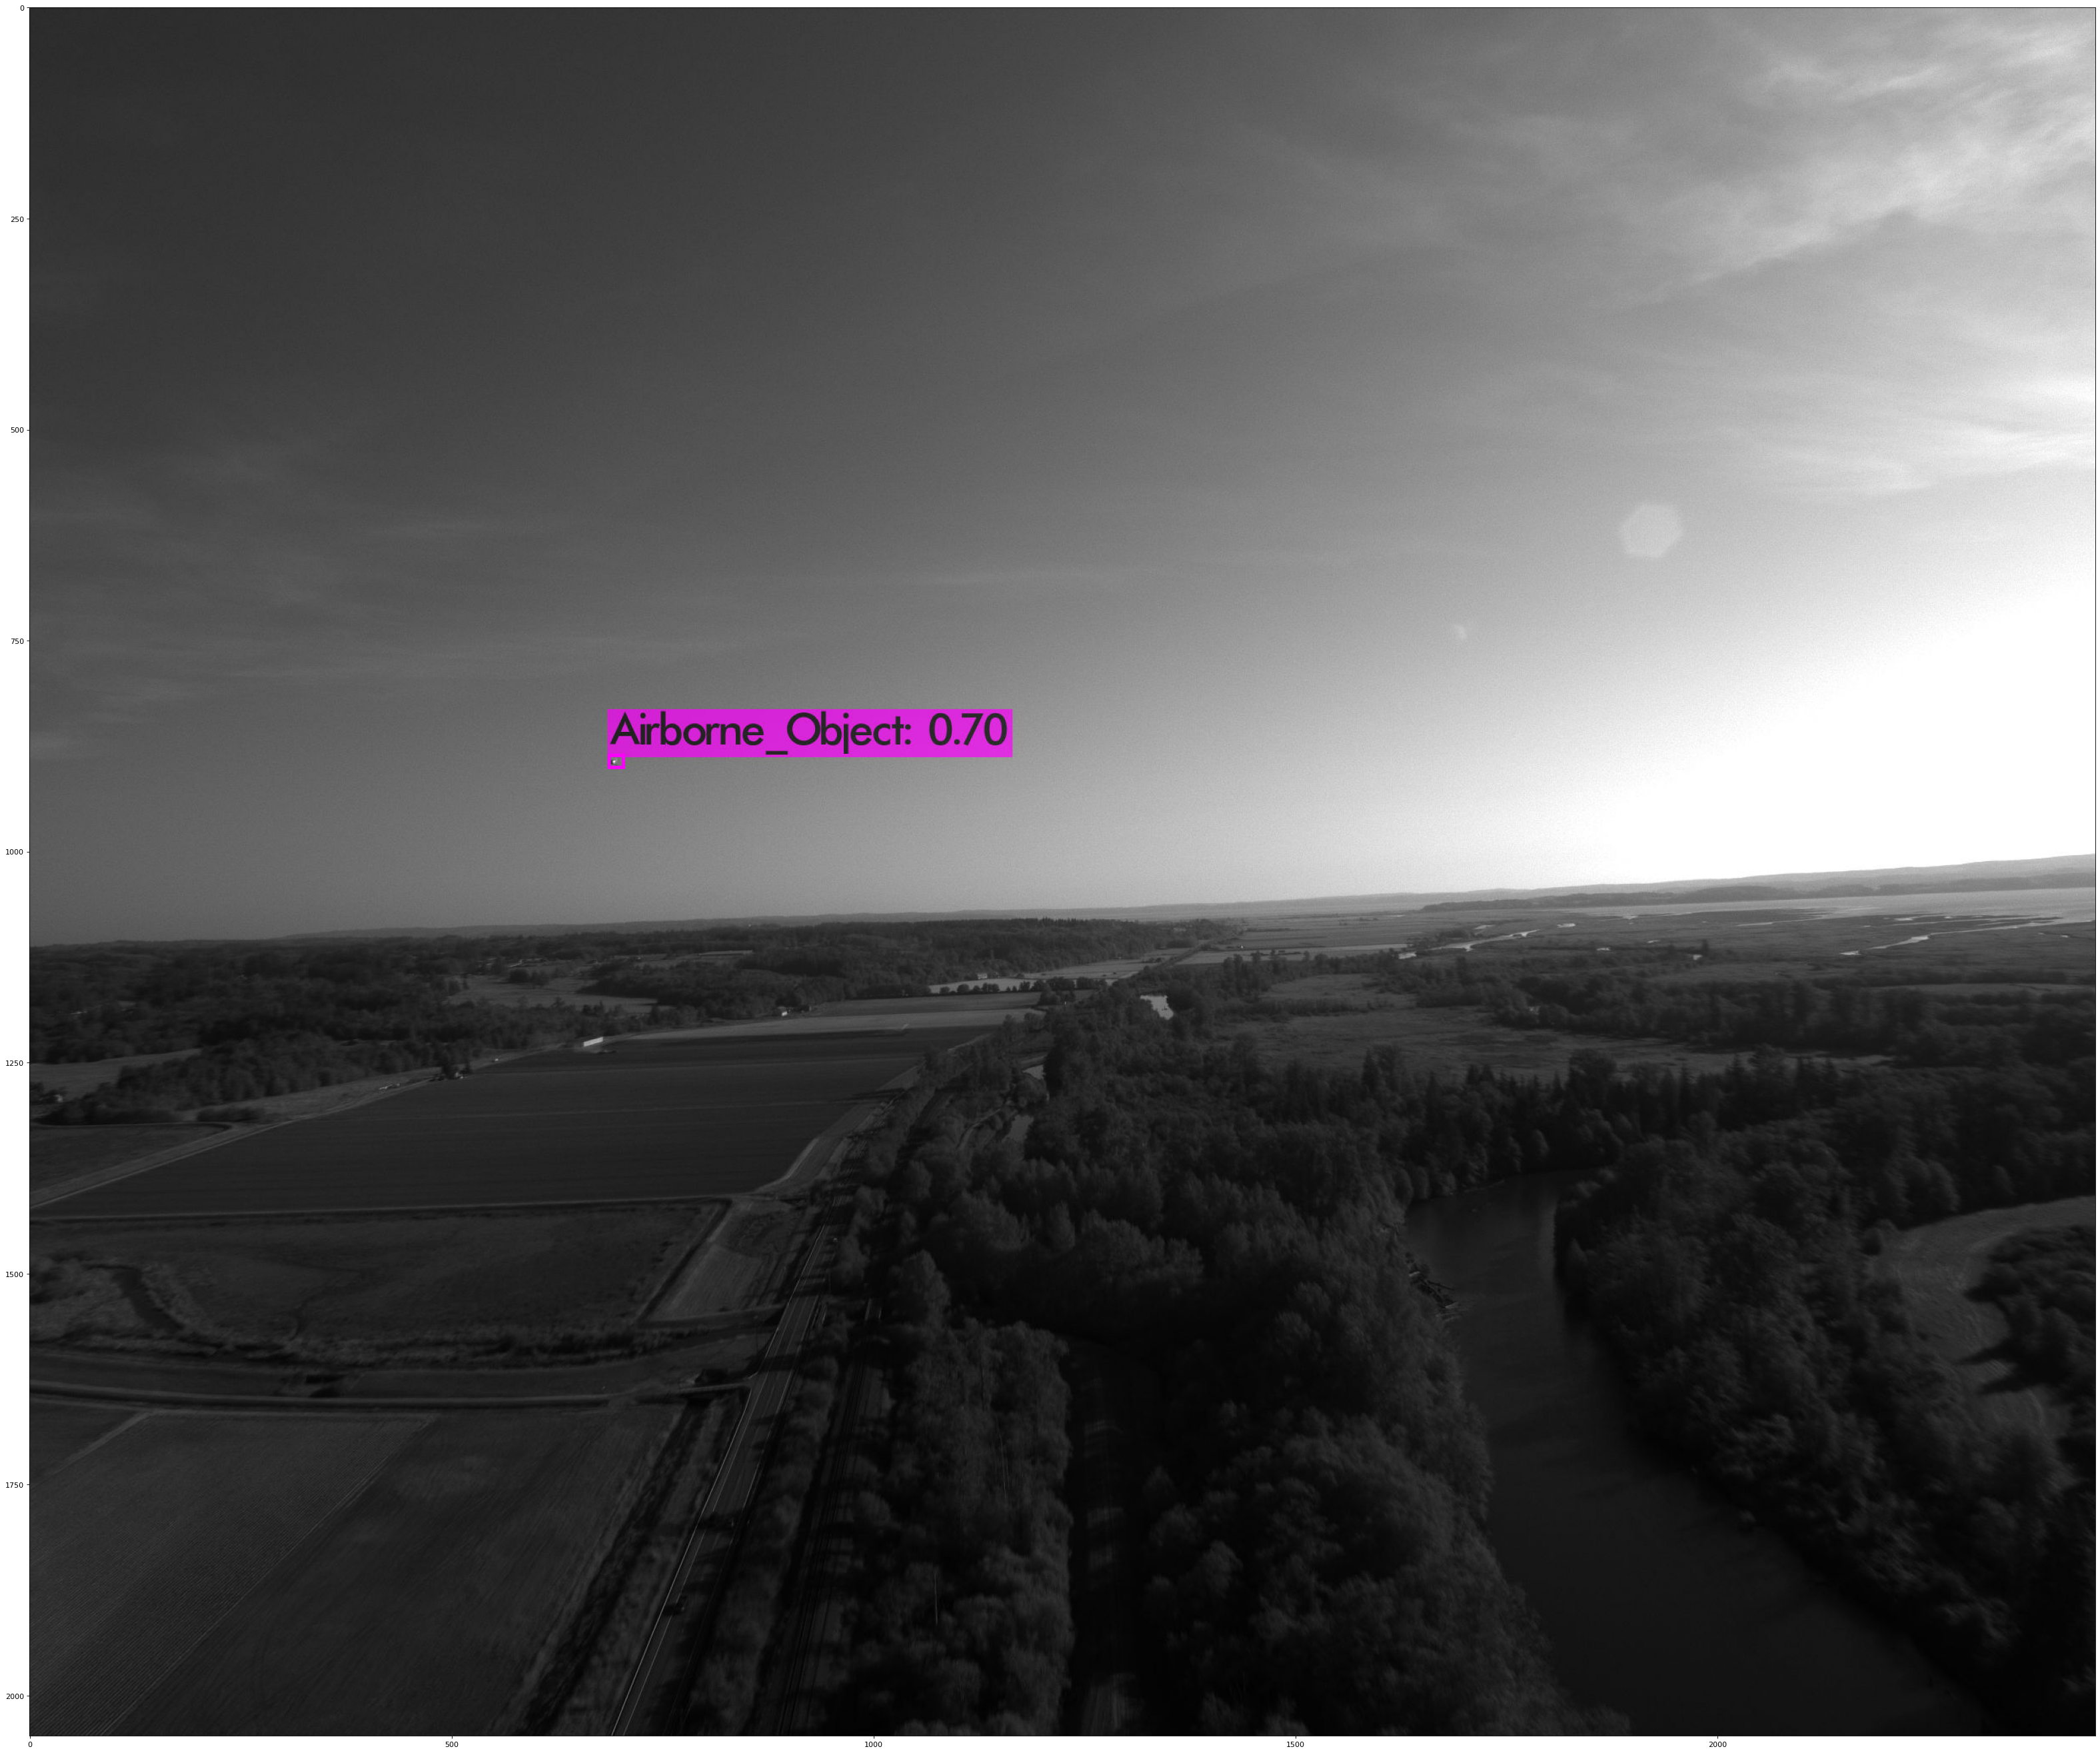

In [13]:
yolo_v3.plot_image('predictions.jpg')

# Evaluation

And now, let's evaluate both models that have just been trained through the loss chart.

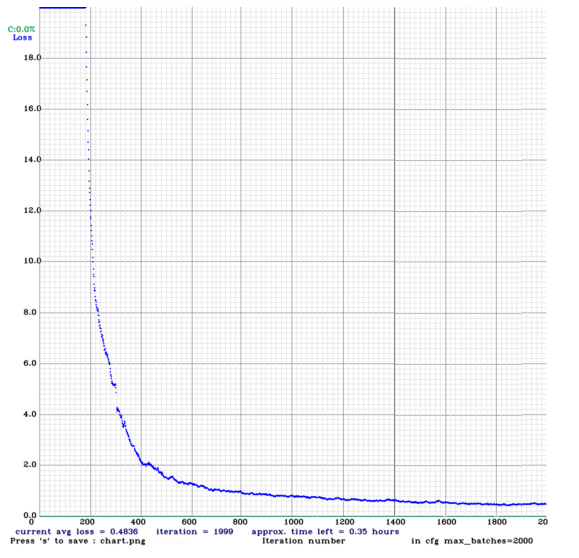

In [14]:
yolo_v3.imShow('chart_yolov3.png')

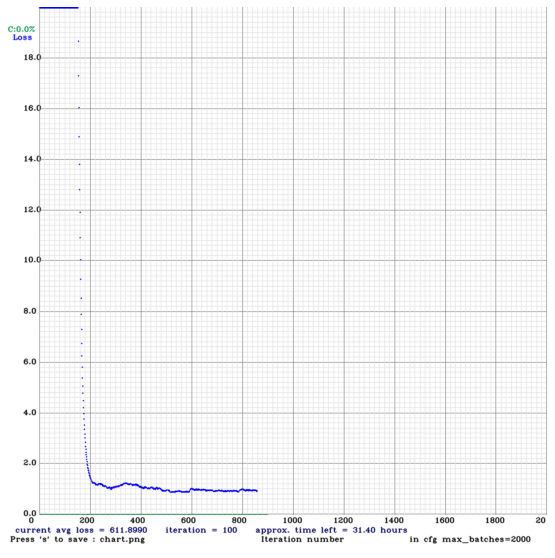

In [15]:
yolo_v3.imShow('chart_yolov4-custom.png')

As we can see, both histograms are convex, and both tend to decrease after each iter. However, **YOLOv3** has earlier training and convergence times. This happens because the data set we currently have for training is very large, as well as **YOLO** usually does not do too well in distinguishing small objects.

Another thing to note, from the 900th iter onwards in **YOLOv3**, the loss function does not decrease too much after every 100 iterations. Therefore, the **YOLOv3** model with the 900th iter weight set will be selected to solve this benchmark.

# 💟 Thanks!
Thanks for following along this tutorial, I hope it worked well for all of you!